In [5]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/Utils")


In [6]:
import gc
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
import matplotlib.pyplot as plt

In [7]:
from funs import *
from cols_list import cols_enem

## Carregando dataset filtrado

In [8]:
enem_trienio = load_trienio_enem(cols_enem)

Tamanho do dataset pré-filtragem:  5095171
Tamanho do dataset pós-filtragem:  1604459
Taxa de filtragem:  0.6851020309230054
Tamanho do dataset pré-filtragem:  5783109
Tamanho do dataset pós-filtragem:  1254237
Taxa de filtragem:  0.7831206363220891
Tamanho do dataset pré-filtragem:  2685053
Tamanho do dataset pós-filtragem:  950911
Taxa de filtragem:  0.6458501936460844


In [9]:
enem_trienio['Q025'] = enem_trienio['Q025'].replace(['A','B'],[0,1])

In [10]:
enem19 = enem_trienio[enem_trienio['NU_ANO']==2019]
enem19 = enem19.compute()

In [11]:
gc.collect()

0

In [12]:
enem19['NT_MEDIA'] = enem19.apply(lambda row: get_medium_score(row), axis=1)

In [14]:
enem19['LOG_NT_MEDIA'] = np.log(enem19['NT_MEDIA'])
enem19['LOG_NT_MT'] = np.log(enem19['NU_NOTA_MT'])

/home/joao/anaconda3/envs/scraping/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/joao/anaconda3/envs/scraping/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [15]:
# Droping nan values from LOG_NT_MEDIA and LOG_NT_MT
enem19 = enem19.dropna(subset=['LOG_NT_MT'])

In [16]:
mt_x_int = enem19[['LOG_NT_MT','Q025']]
mt_x_int = sm.add_constant(mt_x_int)
mt_x_int['Q025'] = mt_x_int['Q025'].astype(float)


In [48]:
test = clean_dataset(mt_x_int)

## Abordagem por Statsmodels

Regressão Quantílica Simples

In [81]:
def fit_model(q):
    res = mod.fit(
        q=q, 
        vcov='robust',
        kernel='epa',
        bandwidth='hsheather', 
        max_iter=1000,
        p_tol=1e-06
    )

    return [q, res.params["Intercept"], res.params["Q025"]] + res.conf_int().loc[
        "Q025"
    ].tolist()


In [82]:
mod = smf.quantreg('LOG_NT_MT ~ Q025', data=test, missing='drop')

In [83]:
quantiles = np.arange(0.05, 0.96, 0.1)

models = [fit_model(x) for x in quantiles]

In [90]:
models = pd.DataFrame(models, columns=["q", "intercept", "B", "lowerbound", "upperbound"])

In [119]:
# OLS para comparação
ols = smf.ols("LOG_NT_MT ~ Q025", data=test, missing='drop').fit()
ols_ci = ols.conf_int().loc["Q025"].tolist()
ols = dict(
    a=ols.params["Intercept"], b=ols.params["Q025"], lb=ols_ci[0], ub=ols_ci[1]
)

### Visualizando modelo

In [126]:
models

,q,intercept,B,lowerbound,upperbound
0,0.05,5.930918,0.034718,0.033843,0.035592
1,0.15,5.989963,0.052909,0.052022,0.053796
2,0.25,6.031646,0.073817,0.072858,0.074776
3,0.35,6.072122,0.092035,0.090986,0.093084
4,0.45,6.111689,0.112672,0.111537,0.113806
5,0.55,6.154216,0.134014,0.132788,0.135240
6,0.65,6.201522,0.153890,0.152642,0.155137
7,0.75,6.258627,0.165106,0.163899,0.166314
8,0.85,6.333812,0.162661,0.161474,0.163849
9,0.95,6.451572,0.150066,0.148624,0.151507


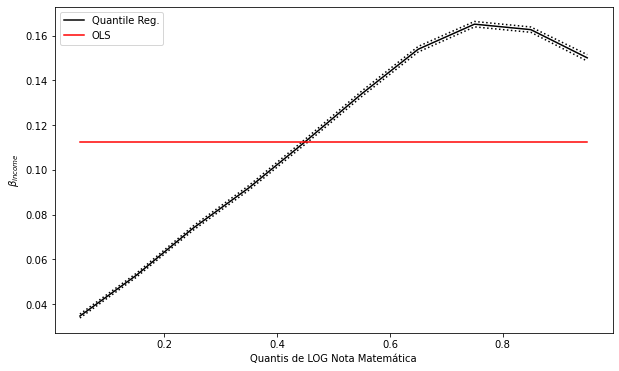

In [125]:
plt.figure(figsize=(10, 6))
n = models.shape[0]
p1 = plt.plot(models.q, models.B, color="black", label="Quantile Reg.")
p2 = plt.plot(models.q, models.upperbound, linestyle="dotted", color="black")
p3 = plt.plot(models.q, models.lowerbound, linestyle="dotted", color="black")
p4 = plt.plot(models.q, [ols["b"]] * n, color="red", label="OLS")
#p5 = plt.plot(models.q, [ols["lb"]] * n, linestyle="dotted", color="red")
#p6 = plt.plot(models.q, [ols["ub"]] * n, linestyle="dotted", color="red")
plt.ylabel(r"$\beta_{income}$")
plt.xlabel("Quantis de LOG Nota Matemática")
plt.legend()
plt.show()

Regressão Quantílica Múltipla

In [128]:
enem19.columns

Index(['NU_ANO', 'TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL',
       'TP_COR_RACA', 'TP_ESCOLA', 'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC',
       'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC',
       'TP_SIT_FUNC_ESC', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC',
       'NU_NOTA_MT', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2',
       'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO',
       'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009',
       'Q010', 'Q012', 'Q019', 'Q022', 'Q024', 'Q025', 'NT_MEDIA',
       'LOG_NT_MEDIA', 'LOG_NT_MT'],
      dtype='object')